In [1]:
# 뉴스기사 요약해보기

In [2]:
!pip install --upgrade summa
!pip install --upgrade nltk 
!pip install beautifulsoup4
!pip install sentencepiece

In [3]:
from importlib.metadata import version
import os, re, warnings, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import summa
from summa.summarizer import summarize
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
nltk.download('stopwords')
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Step 1. 데이터 수집하기

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
89258,"25 killed, 37 injured in Pak suicide attack by...",At least 25 people have been killed and 37 oth...
41170,Kim Jong-un attends first South Korean concert,North Korean leader Kim Jong-un on Sunday beca...
64905,Fence along Afghanistan border will reduce att...,Pakistan's military has said that new fencing ...
27715,And they say only women gossip: Smriti Irani o...,Union Minister Smriti Irani on Sunday posted a...
64351,Mumbai-Nagercoil Express runs with missing whe...,A coach of the Mumbai-Nagercoil Express was fo...
41318,Indore building collapse victims to get Ã¢ÂÂ¹...,Madhya Pradesh Chief Minister Shivraj Singh Ch...
21400,"AIIMS starts door-step test, screening facilit...",AIIMS has started a doorstep test and screenin...
43553,GM invests $100 mn in facilities to build self...,General Motors on Thursday announced it will b...
47070,Hyderabad temple holds special puja to solve b...,The Chilkur Balaji Temple in Hyderabad perform...
31939,Yahoo launches invite-only group messaging app...,Yahoo has launched a group messaging app calle...


In [7]:
# Step 2. 데이터 전처리하기 (추상적 요약)

In [8]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
# # 데이터 전처리 함수
# def preprocess_sentence(sentence):
#     sentence = sentence.lower() # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) 
#     sentence = re.sub('[m]{3,}', 'mm', sentence) 
#     tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
#     return tokens

In [16]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines))

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way start day


In [17]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [18]:
# 전체 headlines 데이터에 대한 전처리 
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [19]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [20]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [21]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [22]:
data.sample(10)

,headlines,text
64252,singapore passport named world powerful passport,singapore passport become powerful world visa ...
26262,nagarjuna confirms star ranbir alia brahm stra,south indian actor nagarjuna confirmed star ra...
43014,demonetisation led tax terrorism yashwant sinha,former finance minister yashwant sinha said de...
33726,states army pakistan army state iaf chief,indian air force chief bs dhanoa said countrie...
67035,siri mistakenly says bulgaria national anthem ...,siri mistakenly told apple user national anthe...
8843,man married girl raped settle case held torturing,mumbai police arrested year old man allegedly ...
93569,ipl site wrongly mentions kohli left handed ba...,official website indian premier league wrongly...
94958,farhan aditya get verbal spat shraddha report,per reports farhan akhtar aditya roy kapur got...
58842,woman syndrome competes us beauty pageant,twenty two year old mikayla holmgren become fi...
36883,nd apple worker arrested self driving car secr...,fbi arrested apple employee jizhong chen alleg...


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.137759251728345


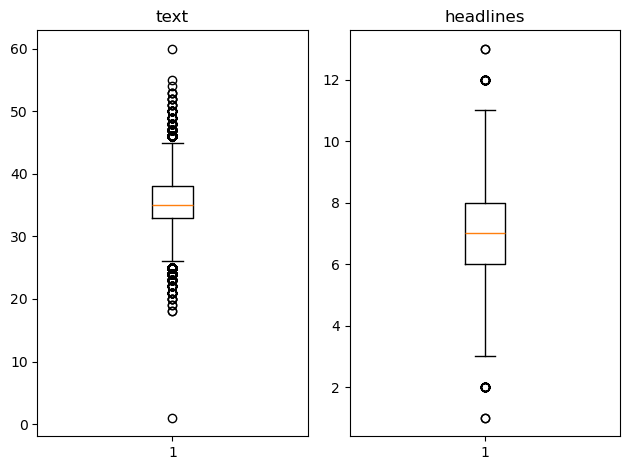

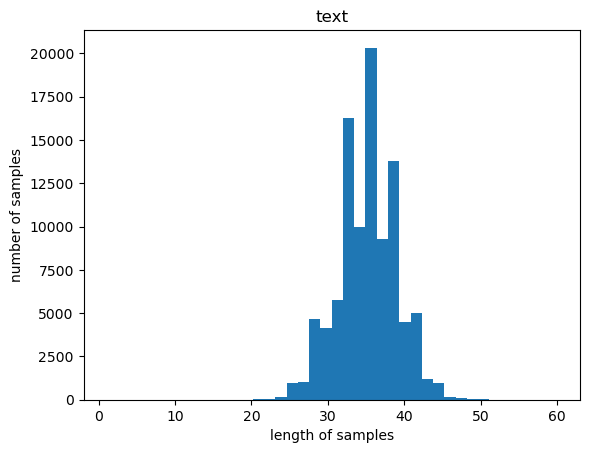

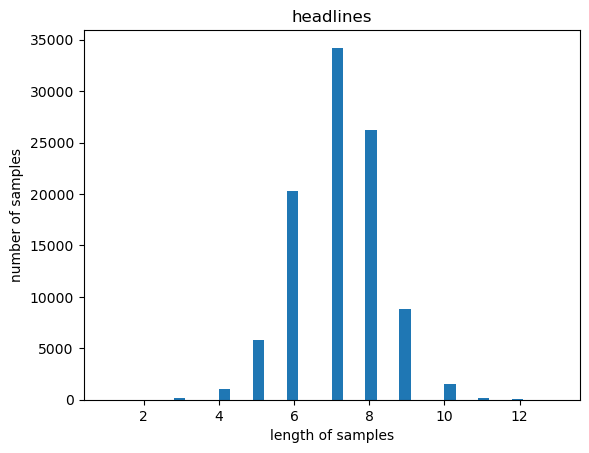

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
text_max_len = 70
headlines_max_len = 15

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 70 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 15 이하인 샘플의 비율: 1.0


In [27]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [29]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15218 93849 48606 ... 45460 25516 56852]


In [31]:
encoder_input_train, encoder_temp, decoder_input_train, decoder_input_temp, decoder_target_train, decoder_target_temp = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.2, random_state=42, shuffle=True
)
encoder_input_valid, encoder_input_test, decoder_input_valid, decoder_input_test, decoder_target_valid, decoder_target_test = train_test_split(
    encoder_temp, decoder_input_temp, decoder_target_temp, test_size=0.5, random_state=42, shuffle=True
)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_valid))
print('검증 레이블의 개수 :', len(decoder_input_valid))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
검증 데이터의 개수 : 9836
검증 레이블의 개수 : 9836
테스트 데이터의 개수 : 9836
테스트 레이블의 개수 : 9836


In [32]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [33]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76334
등장 빈도가 6번 이하인 희귀 단어의 수: 51776
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24558
단어 집합에서 희귀 단어의 비율: 67.82822857442294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0337692130558263


In [34]:
src_vocab_size = 25689

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [35]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_valid_seq = text_to_sequence(encoder_input_valid, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_valid_seq[:3])
print(encoder_input_test_seq[:3])

[[345, 355, 16, 6733, 7070, 68, 2933, 155, 542, 92, 986, 1370, 396, 1726, 140, 85, 5390, 1978, 787, 7070, 619, 986, 1370, 396, 379, 12549, 14, 457, 3208, 3141, 542, 1710, 990, 13352, 2581, 542, 3604, 62, 381, 986, 1370, 396, 358, 6, 17, 125, 45], [11, 707, 8285, 231, 340, 15361, 4001, 7665, 883, 1, 10, 10031, 3176, 4262, 1, 3917, 5891, 411, 180, 8285, 1215, 12, 1586, 1659, 2362, 2549, 3176, 1, 1, 1, 1481, 1347, 1097, 3955, 11, 2], [622, 232, 153, 26, 146, 7259, 2397, 9849, 4702, 44, 1535, 476, 4785, 267, 501, 1233, 7259, 9478, 2670, 4029, 5892, 309, 4823, 3434, 13353, 309, 4785, 146, 3918, 6488, 1, 4867, 19441, 1, 2906, 6335]]
[[556, 28, 433, 3832, 1364, 2952, 377, 2621, 208, 74, 5530, 23423, 2139, 1, 2952, 2952, 11331, 11331, 9998, 150, 378, 320, 1103, 452, 1052, 7402, 800, 2952, 674, 319, 120, 115], [3, 722, 4569, 960, 93, 1899, 20, 338, 1588, 2001, 583, 68, 4569, 101, 1912, 1, 2355, 1704, 1013, 1, 49, 22463, 49, 4739, 49, 393, 3, 1420, 93, 3, 278, 173, 3589, 93, 374, 1193], [6, 35, 

In [36]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

In [37]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29944
등장 빈도가 5번 이하인 희귀 단어의 수: 19717
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10227
단어 집합에서 희귀 단어의 비율: 65.84624632647609
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.921514868582527


In [38]:
tar_vocab_size = 10791
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_valid_seq = text_to_sequence(decoder_input_valid, tar_vocab)
decoder_target_valid_seq = text_to_sequence(decoder_target_valid, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 152, 1363, 303, 87, 622, 869, 143, 2169, 4965], [2, 66, 35, 4251, 1, 4502, 1, 6228, 2886], [2, 363, 1, 1, 78, 2647, 25, 4038], [2, 2887, 3324, 7570, 3824, 100, 1, 1014], [2, 513, 791, 642, 1579, 1148, 2747, 1684, 7]]
target
decoder  [[152, 1363, 303, 87, 622, 869, 143, 2169, 4965, 3], [66, 35, 4251, 1, 4502, 1, 6228, 2886, 3], [363, 1, 1, 78, 2647, 25, 4038, 3], [2887, 3324, 7570, 3824, 100, 1, 1014, 3], [513, 791, 642, 1579, 1148, 2747, 1684, 7, 3]]


In [39]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_valid = [index for index, sentence in enumerate(decoder_input_valid) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 검증 데이터의 개수 :', len(drop_valid))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_valid = [sentence for index, sentence in enumerate(encoder_input_valid) if index not in drop_valid]
decoder_input_valid = [sentence for index, sentence in enumerate(decoder_input_valid) if index not in drop_valid]
decoder_target_valid = [sentence for index, sentence in enumerate(decoder_target_valid) if index not in drop_valid]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('검증 데이터의 개수 :', len(encoder_input_valid))
print('검증 레이블의 개수 :', len(decoder_input_valid))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 검증 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
검증 데이터의 개수 : 9836
검증 레이블의 개수 : 9836
테스트 데이터의 개수 : 9836
테스트 레이블의 개수 : 9836


In [40]:
# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_valid = pad_sequences_pytorch(encoder_input_valid_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_valid = pad_sequences_pytorch(decoder_input_valid_seq, maxlen=headlines_max_len)
decoder_target_valid = pad_sequences_pytorch(decoder_target_valid_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

In [41]:
# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [42]:
CFG = {
    'embedding_dim': 128,                  
    'hidden_size': 256,                        
    'num_layers': 3,                      
    'dropout': 0.4,                            
    'epochs': 50,                              
    'batch_size': 128,                          
    'learning_rate': 1e-3,                                           
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'patience': 2
}

In [43]:
# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, CFG['embedding_dim'], CFG['hidden_size'], CFG['num_layers'], CFG['dropout'])

In [44]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, CFG['embedding_dim'], CFG['hidden_size'], CFG['dropout'], CFG['num_layers'])

In [45]:
# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size, CFG['hidden_size'])
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(25689, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10791, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=10791, bias=True)
)


In [46]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, CFG['hidden_size'])
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(25689, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10791, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10791, bias=True)
)


In [47]:
device = CFG['device']
model.to(device)

# Hyperparameters
batch_size = CFG['batch_size']
epochs = CFG['epochs']
learning_rate = CFG['learning_rate']
patience = CFG['patience']

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=CFG['learning_rate'])

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
valid_dataset = TensorDataset(encoder_input_valid, decoder_input_valid, decoder_target_valid)
# test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=CFG['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG['batch_size'], shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False)

In [48]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in valid_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [49]:
# 학습 실행
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=CFG['epochs'], patience=CFG['patience'])

  2%|▏         | 1/50 [00:29<24:17, 29.74s/it]

Epoch 1/50 | Train Loss: 7.1180 | Val Loss: 6.8161


  4%|▍         | 2/50 [01:00<24:18, 30.39s/it]

Epoch 2/50 | Train Loss: 6.5595 | Val Loss: 6.1510


  6%|▌         | 3/50 [01:32<24:17, 31.00s/it]

Epoch 3/50 | Train Loss: 5.8795 | Val Loss: 5.6198


  8%|▊         | 4/50 [02:03<23:42, 30.92s/it]

Epoch 4/50 | Train Loss: 5.3939 | Val Loss: 5.2886


 10%|█         | 5/50 [02:34<23:14, 31.00s/it]

Epoch 5/50 | Train Loss: 5.0179 | Val Loss: 5.0664


 12%|█▏        | 6/50 [03:05<22:48, 31.10s/it]

Epoch 6/50 | Train Loss: 4.7178 | Val Loss: 4.9108


 14%|█▍        | 7/50 [03:36<22:16, 31.08s/it]

Epoch 7/50 | Train Loss: 4.4675 | Val Loss: 4.8026


 16%|█▌        | 8/50 [04:07<21:47, 31.14s/it]

Epoch 8/50 | Train Loss: 4.2514 | Val Loss: 4.7348


 18%|█▊        | 9/50 [04:39<21:17, 31.16s/it]

Epoch 9/50 | Train Loss: 4.0622 | Val Loss: 4.6849


 20%|██        | 10/50 [05:10<20:45, 31.13s/it]

Epoch 10/50 | Train Loss: 3.8959 | Val Loss: 4.6504


 22%|██▏       | 11/50 [05:41<20:13, 31.12s/it]

Epoch 11/50 | Train Loss: 3.7435 | Val Loss: 4.6330


 24%|██▍       | 12/50 [06:12<19:42, 31.13s/it]

Epoch 12/50 | Train Loss: 3.6047 | Val Loss: 4.6192


 26%|██▌       | 13/50 [06:43<19:12, 31.14s/it]

Epoch 13/50 | Train Loss: 3.4770 | Val Loss: 4.6261


 26%|██▌       | 13/50 [07:14<20:36, 33.43s/it]

Epoch 14/50 | Train Loss: 3.3573 | Val Loss: 4.6450
Early stopping triggered at epoch 14


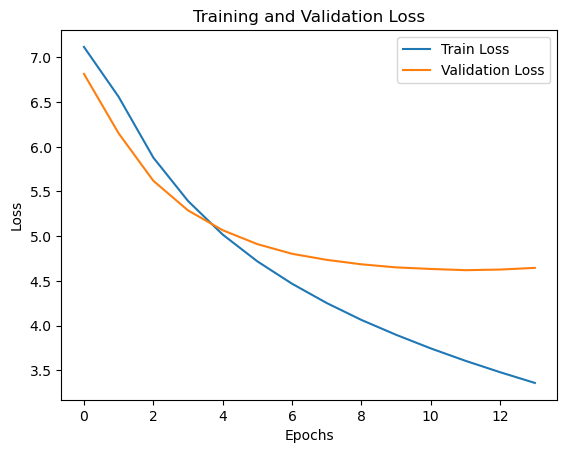

In [50]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [51]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [52]:
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = CFG['num_layers']  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
hidden_size = CFG['hidden_size']
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

In [53]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)

In [54]:
def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [55]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [56]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : former personal assistant chinese born billionaire guo <UNK> filed million lawsuit new york accusing raping year old woman said lured new york guise one week business trip said held captive subjected repeated acts mental cruelty sexual violence
실제 요약 : chinese billionaire sued crore raping assistant
예측 요약 :  dead post space students pic money money money show show show show show show


원문 : uttar pradesh mughalsarai railway station renamed deen dayal upadhyay railway station bid revive legacy pandit upadhyay found dead near station centre approval uttar pradesh government proposal rename station attracted criticism opposition rajya sabha earlier year
실제 요약 : <UNK> station renamed <UNK> <UNK> <UNK> station
예측 요약 :  dead post like students like ever money money singh two ceo last kohli show


원문 : uttar pradesh chief minister yogi adityanath wednesday said bjp put good fight leadership prime minister narendra modi rajasthan madhya pradesh assembly elections calling victory defeat tw

/tmp/ipykernel_2296/518603636.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
/tmp/ipykernel_2296/3400655303.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  reports pic used pic pic court would two pay kohli high show show show


원문 : team india chief selector msk prasad said karnataka batsman mayank agarwal scored record plus runs domestic cricket last season get due soon identified potential mayank keeping track time done well prasad added prasad said team india players rested windies series
실제 요약 : mayank agarwal get due soon team india chief selector
예측 요약 :  highest post highest highest students highest crore actor facebook two year last back show


원문 : india third targeted country phishing scams according <UNK> quarterly fraud report january march period phishing accounted cyber attacks us canada brazil top countries targeted phishing mobile app fraud transactions increased past three years report added
실제 요약 : india rd targeted country <UNK> scams report
예측 요약 :  dead post like students like asks like like state singh mp gst gst show


원문 : journalist released years old picture former us president barack obama nation islam

In [57]:
# Step 5. Summa을 이용해서 추출적 요약해보기

In [58]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
new_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [59]:
for i in range(50):
    original = new_data['text'].iloc[i]           
    gold = data['headlines'].iloc[i]          
    summa_sum = summarize(original, ratio=0.6)
    if not summa_sum:
        summa_sum = summarize(original, words=15) or "(요약 불가)"

    print("원문 :", original)
    print("실제 요약 :", gold)
    print("Summa 요약 :", summa_sum)
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upgrad learner switches career ml al salary hike
Summa 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : delhi techie wins free food swiggy one year cred
Summa 요약 : Users get one CRED coin per rupee of bill paid, which can be used to

In [60]:
# 불용어 제거 안했을 때
#  2%|▏         | 1/50 [00:50<41:09, 50.41s/it]
# Epoch 1/50 | Train Loss: 7.2574 | Val Loss: 6.7491
#   4%|▍         | 2/50 [01:39<39:42, 49.64s/it]
# Epoch 2/50 | Train Loss: 6.5363 | Val Loss: 6.1260
#   6%|▌         | 3/50 [02:29<38:59, 49.78s/it]
# Epoch 3/50 | Train Loss: 5.8645 | Val Loss: 5.5935
#   8%|▊         | 4/50 [03:18<38:04, 49.67s/it]
# Epoch 4/50 | Train Loss: 5.3479 | Val Loss: 5.2393
#  10%|█         | 5/50 [04:08<37:17, 49.73s/it]
# Epoch 5/50 | Train Loss: 4.9489 | Val Loss: 4.9906
#  12%|█▏        | 6/50 [04:58<36:27, 49.72s/it]
# Epoch 6/50 | Train Loss: 4.6222 | Val Loss: 4.8201
#  14%|█▍        | 7/50 [05:48<35:37, 49.70s/it]
# Epoch 7/50 | Train Loss: 4.3456 | Val Loss: 4.6752
#  16%|█▌        | 8/50 [06:37<34:46, 49.68s/it]
# Epoch 8/50 | Train Loss: 4.1060 | Val Loss: 4.5640
#  18%|█▊        | 9/50 [07:27<33:56, 49.67s/it]
# Epoch 9/50 | Train Loss: 3.8994 | Val Loss: 4.4934
#  20%|██        | 10/50 [08:17<33:08, 49.70s/it]
# Epoch 10/50 | Train Loss: 3.7154 | Val Loss: 4.4199
#  22%|██▏       | 11/50 [09:07<32:20, 49.76s/it]
# Epoch 11/50 | Train Loss: 3.5492 | Val Loss: 4.3846
#  24%|██▍       | 12/50 [09:57<31:32, 49.81s/it]
# Epoch 12/50 | Train Loss: 3.4014 | Val Loss: 4.3386
#  26%|██▌       | 13/50 [10:46<30:44, 49.85s/it]
# Epoch 13/50 | Train Loss: 3.2647 | Val Loss: 4.3221
#  28%|██▊       | 14/50 [11:36<29:54, 49.84s/it]
# Epoch 14/50 | Train Loss: 3.1414 | Val Loss: 4.3007
#  30%|███       | 15/50 [12:26<29:02, 49.78s/it]
# Epoch 15/50 | Train Loss: 3.0291 | Val Loss: 4.2970
#  32%|███▏      | 16/50 [13:15<28:10, 49.72s/it]
# Epoch 16/50 | Train Loss: 2.9235 | Val Loss: 4.2865
#  34%|███▍      | 17/50 [14:05<27:20, 49.73s/it]
# Epoch 17/50 | Train Loss: 2.8270 | Val Loss: 4.2686
#  36%|███▌      | 18/50 [14:55<26:32, 49.76s/it]
# Epoch 18/50 | Train Loss: 2.7353 | Val Loss: 4.2748
#  36%|███▌      | 18/50 [15:45<28:00, 52.53s/it]
# Epoch 19/50 | Train Loss: 2.6515 | Val Loss: 4.2845
# Early stopping triggered at epoch 19

In [61]:
table = {
    '평가 기준': ['문법 완성도', '핵심 단어 포함'],
    '추상적 요약 (Seq2Seq with Attention)': [
        '매우 낮음. 문법적으로 완성된 문장을 생성하지 못하고 관련 없는 단어들을 나열하는 수준.',
        '매우 낮음. 원문의 내용과 거의 관련 없는 단어들을 반복적으로 생성하며, 핵심 내용을 전혀 반영하지 못함.'
    ],
    '추출적 요약 (Summa)': [
        '매우 높음. 원문에서 직접 문장을 추출하므로 문법적으로 완벽하고 자연스러움.',
        '대체로 우수함. 원문의 핵심 문장을 추출하여 주요 키워드를 대부분 포함.'
    ]
}

df = pd.DataFrame(table)

df

,평가 기준,추상적 요약 (Seq2Seq with Attention),추출적 요약 (Summa)
0,문법 완성도,매우 낮음. 문법적으로 완성된 문장을 생성하지 못하고 관련 없는 단어들을 나열하는 수준.,매우 높음. 원문에서 직접 문장을 추출하므로 문법적으로 완벽하고 자연스러움.
1,핵심 단어 포함,"매우 낮음. 원문의 내용과 거의 관련 없는 단어들을 반복적으로 생성하며, 핵심 내용...",대체로 우수함. 원문의 핵심 문장을 추출하여 주요 키워드를 대부분 포함.


In [62]:
# review
# 이번 프로젝트에서 Seq2Seq 어텐션 메커니즘을 적용하여 뉴스 요약을 수행하였으나, 전반적인 요약 품질은 기대에 미치지 못했다.
# 불용어 처리를 제거했을때가 그나마 학습 안정성은 높고 검증로스도 가장 낮게 나왔다(Val Loss: 4.2865).
# 프로젝트에서는 불용어 처리를 적용하라고 했기 때문에 불용어 처리를 적용했다.
# 하지만 사실상 불용어 처리를 하든 안하든 예측 결과가 심각하게 좋지 않게 나왔다.
# 그 이유를 생각해 보자면 첫째, 텍스트 데이터 전처리 과정에서 정보 손실이 과도하게 발생하였다.
# HTML 태그, 특수문자, 불필요한 기호 제거 과정에서 의미 있는 숫자, 고유명사, 기호 등이 함께 삭제되었다.
# 따라서 모델이 핵심 정보를 학습하는 데 문제가 생겼다.
# 둘째, 토큰화를 단순 띄어쓰기 기반으로 수행하여, 복합 명사나 고유명사가 잘게 분리되었다.
# 문맥적으로 중요한 단어가 띄어쓰기 기준으로 나눠져서 단어 의미가 손실되었다.
# 셋째, 사전학습된 임베딩 벡터를 활용하지 않고 처음부터 임베딩을 학습하다 보니, 초기 학습 안정성이 낮았다. 
# 충분한 데이터셋 규모와 학습 시간이 확보되지 않은 상태에서 단어 표현 학습이 불안정하게 이루어졌다.
# 그 결과로, 예측 시 의미 없는 단어 반복, 비문 생성이 빈번히 발생했다.
# Summa는 단어 및 문장 패턴을 직접 학습하는 것이 아니라, 입력 문서에서 핵심 문장을 통계적으로 추출하기 때문에 안정적으로 결과를 생성할 수 있었다.
# 실험 결과, Summa 요약은 문법 완성도와 핵심 정보 보존 측면에서 Seq2Seq 모델보다 훨씬 우수한 성능을 보였다.
# 향후 개선 방향으로는 텍스트 데이터의 전처리를 어떻게 하는지가 일단 제일 중요한 과제이다. 
# 이 문제를 해결한 뒤, 다른 토크나이저를 사용해서 희소단어 처리를 잘 해야한다.
# 모델로는 트랜스포머 기반의 인코더 디코더 구조를 가진 BART 모델을 활용해서 뉴스요약을 다시 진행해봐야겠다.
# 사전학습된 BART 기반 뉴스 요약을 진행하면, 대규모 코퍼스에서 이미 학습된 언어 이해 능력을 활용할 수 있기 때문에 
# 현재 Seq2Seq 모델에서 나타난 불안정성과 품질 저하 문제를 크게 개선할 수 있을 것으로 보인다.
# 현재 텍스트 데이터 처리에 대한 이해도가 매우 낮은 상황인거같다. 트랜스포머를 배우고 그 이후 NLP 과정에 들어가기 전까지
# 이 부분을 좀 더 많이 학습해야할거같다.